# Introduction to optimal interpolation and variational analysis

Alexander Barth, Aida Alvera Azcárate, Pascal Joassin, Jean-Marie Beckers, Charles Troupin.

Available under the [Creative Commons Attribution-ShareAlike 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license.


## The gridding problem

$\newcommand{\vect}[1] {{\mathbf #1}}$
Gridding is the determination of a field $\phi(\vect{r})$, on a regular
grid of positions $\vect{r}$ based on arbitrarily located
observations.  Often the vector $\vect{r}$ is on a 2D, 3D or even 4D space.

<img src="Images/oi_used_data.png" style="width: 300px; display: inline"> $\rightarrow$
<img src="Images/oi_field.png" style="width: 300px; display: inline">

* In oceanography, _in situ_ observations are sparse, and the fewer observations are available, the harder the gridding problem is.
* Observations are inhomogeneously distributed in space and time (more observations in the coastal zones and in summer).
* The variability of the ocean is the sum of various processes occurring at different spatial and temporal scales. 

This notebook uses Julia 1.0 and versions above, which can be downloaded from https://julialang.org/downloads/, and the following packages:           
[MAT](https://github.com/JuliaIO/MAT.jl) (to read MATLAB .mat files),      
[PyPlot](https://github.com/JuliaPy/PyPlot.jl) (to generate plots) and           
[DIVAnd](https://github.com/gher-ulg/DIVAnd.jl) (for the interpolation).     

To install these packagers, enter the [Pkg REPL-mode](https://docs.julialang.org/en/v1/stdlib/Pkg/index.html#Getting-Started-1) (hit ] in the julia prompt) and type
```julia
add MAT
add PyPlot
add IJulia
add DIVAnd
```

In [25]:
using MAT
using PyPlot

if VERSION >= v"0.7"
    using Statistics
else
    using Compat: range
end

## Load the data
Stored in the files `dan_field.mat` and `dan_obs_points.mat`:
* `f`: the (full) field
* `F`: the observations (without noise)
* `Fe`: the observations (with noise)
* `X`, `Y`: the location of the observations
* `x`, `y`: the grid point of the field `f`
* `mask`: land-sea mask (true corresponds to sea and false to land)
* `pm`: the inverse of the resolution in the `x` direction
* `pn`: the inverse of the resolution in the `y` direction

In [2]:
mf = matopen("./data/dan_field.mat")
f = read(mf,"f")
F = read(mf,"F")[:]
Fe = read(mf,"Fe")[:]
close(mf)

mf = matopen("./data/dan_obs_points.mat")
X = read(mf,"X")[:]
Y = read(mf,"Y")[:]
x = read(mf,"x")
y = read(mf,"y")
mask = read(mf,"mask") .== 1
close(mf)

pm = ones(size(mask))*5;
pn = ones(size(mask))*5;

@show size(x);

size(x) = (50, 50)


In [3]:
f2 = copy(f);
f2[.!mask] .= NaN;

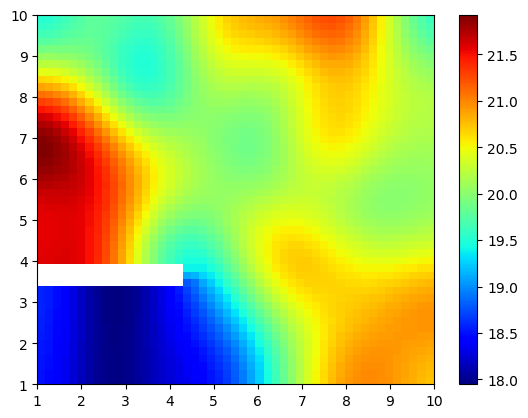

In [4]:
pcolor(x,y,f2; cmap = "jet"); 
colorbar();

(Hypothetical) example of oceanographic field.

* This figure shows an idealized square domain with a barrier (`e.g.` a peninsula or a dike).
* This field is the true field  that we want to reconstruct based on observations. Let's assume that the field represents temperature. 
* The barrier suppresses the exchanges between each side of it.
* The field varies smoothly over some length-scale.

This is a plotting function that we will reused later

In [5]:
# common colorbar range
caxis = [16.5,22]

function plotfield(f2; ca = caxis)
  f2 = copy(f2);
  f2[.!mask] .= NaN;
  contourf(x,y,f2,20; cmap="jet", vmin = ca[1], vmax = ca[2]); 
  #clim(ca);

  colorbar()
  plot(X,Y,"k.");
  return nothing
end

# plot the field and compare to the true solution
function plotfieldcmp(f2)
    figure(figsize=(15,6))
    subplot(1,2,2)
    plotfield(f)
    title("true field")
    subplot(1,2,1)
    plotfield(f2)
end

plotfieldcmp (generic function with 1 method)

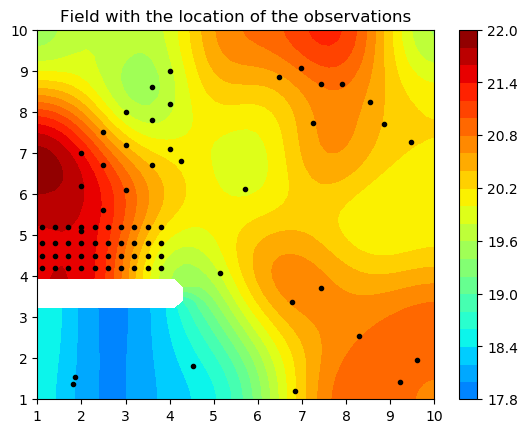

In [6]:
plotfield(f); 
title("Field with the location of the observations");

* In regions where a measurement campaign has been carried out, a higher spatial coverage is achieved. 
* Large gaps are also present. 
* Based on the value of the field at the shown location, we will estimate the true field.


Values of the true field extracted at the location of the observations

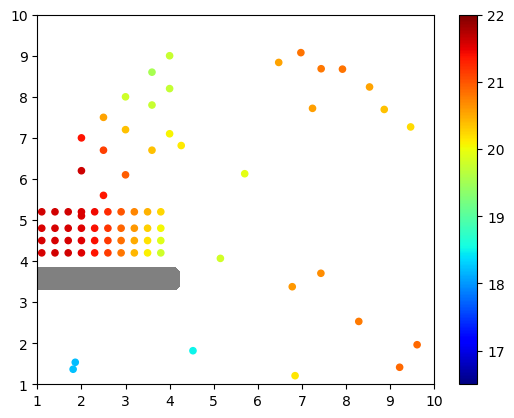

In [7]:
contourf(x,y,mask; levels = [0,0.5], colors = [[.5,.5,.5]]) 
scatter(X,Y,20,F; cmap="jet")
clim(caxis)
colorbar();

* some information about the position of the
structures and fronts is lost 
* no method can provide exactly the true field. But the
more information about its structure we include in the
analysis, the closer we can get to the true field.


## Observation errors

Observations are in general affected by different error sources and
other _problems_ that need to be taken into account:

* _Instrumental errors_: limited precision or possible bias of the sensor.
* _Representativeness errors_: the observations do not necessarily
  corresponds to the field we want to obtain. For example, we want to
  obtain a monthly average, but the observations are instantaneous (or
  averages over a very short period of time).
* _Synopticity errors_: all observations are not taken at the same time.
* Other errors sources: human errors (e.g. permutation of
  longitude and latitude), transmission errors, malfunctioning of the
  instrument, wrong decimal separators...

Quality control is an important step to exclude suspicious data from
the analysis. But since this is a subjective decision, the data should
never be deleted but *flagged* as suspicious or bad data.

Let's plot the observations with noise (`Fe`):

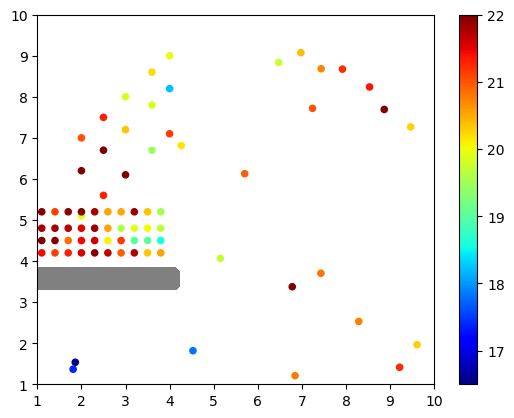

In [8]:
contourf(x,y,mask; levels = [0,0.5], colors = [[.5,.5,.5]]) 
scatter(X,Y,20,Fe; cmap = "jet")
clim(caxis)
colorbar();

* a random perturbation was added to the observations.
* This simulates the impact of the different error sources. 
* To simplify matters, each observation was perturbed independently.

## Data analysis and gridding methodologies

Because observations have errors, it is always better to produce a
field approximation and never a strict interpolation. 

<img src="Images/dan_griddata.png" style="width: 400px; display: inline" >
<img src="Images/dan_field.png" style="width: 400px; display: inline" >


* Gridded field using linear interpolation. This method is
  implemented in the function `griddata` of MATLAB and GNU Octave. Right panel shows true field.
  
* This figure shows what would happen if the observations would have been interpolated linearly. 
* The domain is decomposed into triangles where the vertices are the location of the data points based on the Delaunay triangulation. 
* Within each triangle, the value is interpolated linearly. 
* The noise on the observations is in general amplified when higher order schemes, such as cubic interpolation, are used.


There are a number of methods that have been traditionally used to
solve the gridding problem:

* Subjective: drawing by hand
* Objective: predefined mathematical operations


<img src="Images/tropical_storm_claudette.jpg" style="width: 600px" >

Isohyet (lines of constant precipitation) drawn by hand (from http://www.srh.noaa.gov/hgx/hurricanes/1970s.htm)



## Objective analysis

As opposed to the subjective method, objective analysis techniques aim
to use mathematical formulations to infer the value of the field at
unobserved locations based on the observations.

* first guess is removed from observations
* Gridding procedure (also called "analysis"):

$$
\mbox{Gridded field} = \mbox{First guess of field} + \mbox{weighted sum of observation}
$$

There are several ways to define the
weights, which result in different gridding
techniques. We will review in the following the most used gridding
methods.

### Cressman method

Cressman weights depend only on the distance between the location
 where the value of the field should be estimated and the
location of the observation:

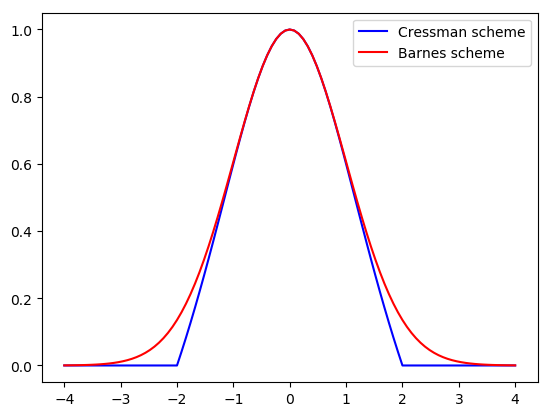

In [9]:
d = range(-4,stop=4,length=101);
R = 2;
w = (R.^2 .- d.^2) ./ (R.^2 .+ d.^2);
w[w .< 0] .= 0;
plot(d,w,"b", label = "Cressman scheme")

R = 1;
w = exp.(-d.^2 ./ (2*R.^2));
plot(d,w,"r"; label = "Barnes scheme")

legend();

The search radius is the typical control parameter and defines the
length-scale over which an observation is used.  This length scale
can be made to vary in space depending on data coverage and/or
physical scales. This parameter is chosen by the users based on their
knowledge of the domain and the problem.


In [10]:
include("cressman2.jl")

cressman2 (generic function with 1 method)

In [11]:
R = 2.

fi = cressman2(R,X,Y,Fe,x,y);

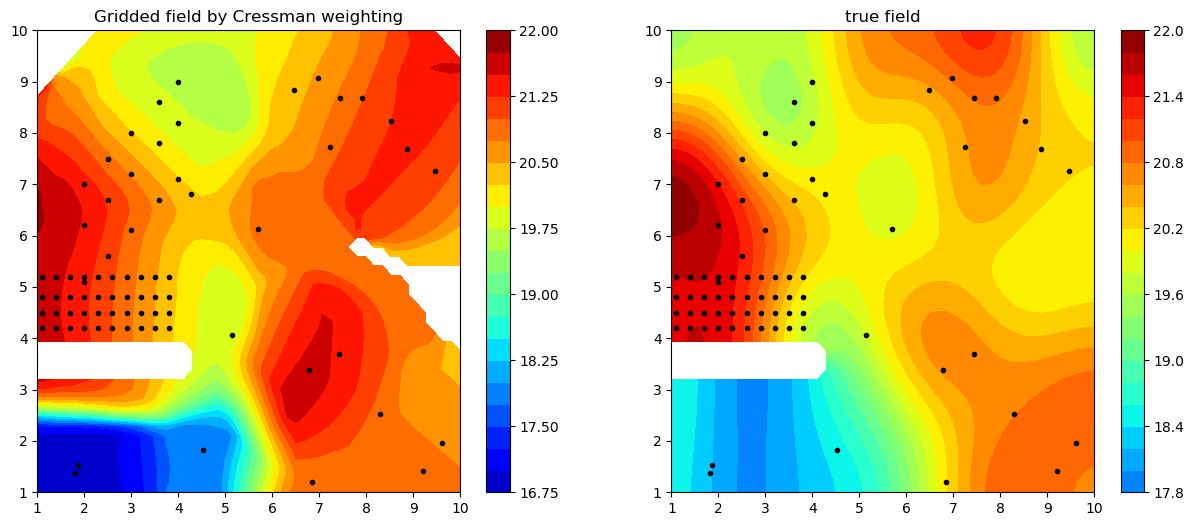

In [12]:
plotfieldcmp(fi); title("Gridded field by Cressman weighting");

The Cressman weighting is a very simple and numerically quite
efficient method. However, it suffers from some limitations which are
apparent in the previous figure.

* No estimate can be obtained at locations when no observation is
  located within the $R$.
* In regions with very few observations, the method can return a
  discontinuous field.
* The presence of barriers
  cannot be taken into account easily.
* All observations are assumed to have a similar error
  variance since the weighting is based only on distance.

* As a variant of the Cressman weights, other weighting functions can be defined. In the Barnes scheme, the weights are defined using a Gaussian function


In [13]:
fi = cressman2(R/2,X,Y,Fe,x,y; method = :barnes);

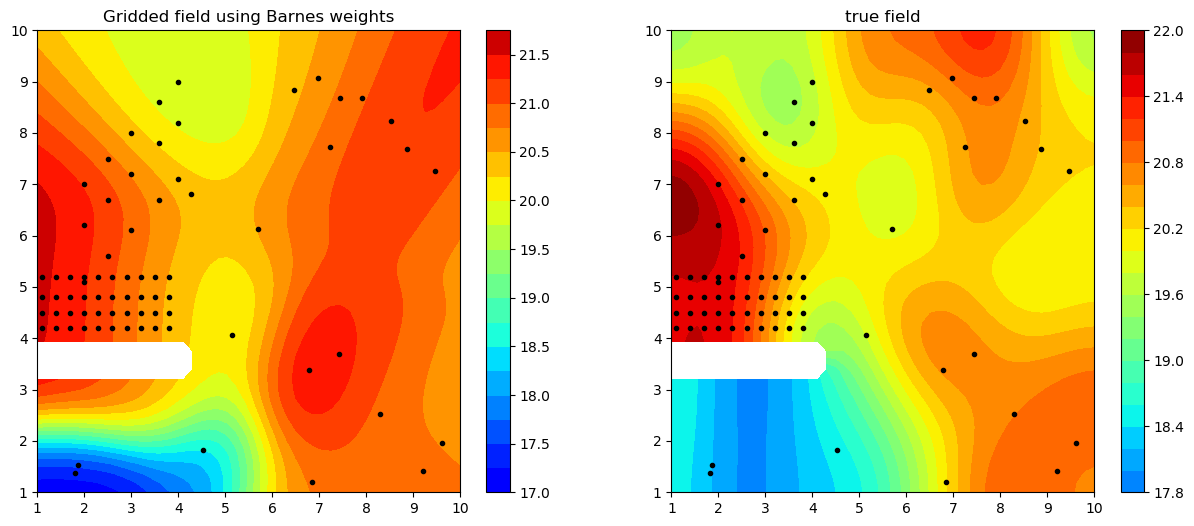

In [14]:
plotfieldcmp(fi); title("Gridded field using Barnes weights");

## Optimal interpolation

*  The first guess and the observations have errors
*  These errors are characterized by the error covariance
*  Optimal interpolation seeks the optimal combination between the first guess and the observations

### Error covariances

*  Need to be specified for observation and first guess
*  Error covariances describe __how different variables or the same
variable at different locations are related in average__. 
*  The error covariance is in general a matrix.
*  the square root of the diagonal elements is the average error of the observations and the first guess
*  the off-diagonal elements describe the relationships between the variables
*  Covariance is directly related to the correlation

### Assumptions
Hypotheses concerning those errors:
*  observations and the first guess are __unbiased__, _i.e._ the error is zero in average.
*  __error covariance matrices are known__. Those matrices are related to the expected magnitude of the error.
*  the error of the first guess is __independent__ of the observation errors.


### Analysis

The optimal interpolation (OI)
scheme can be derived as the Best Linear Unbiased Estimator (BLUE) of
the true state which has the following properties:

*  The estimator __is linear__ in the first guess and observations
*  The estimator is __not biased__
*  This estimate has a __minimal total variance__, _i.e._ no
    other estimator would have an error variance lower that the BLUE
    estimator.

\newslide
From these assumptions the optimal weights of the observations can be derived to grid the field.
The optimal weights depend on the error covariances. In particular,

*  Large expected error of observations compared to first guess $\rightarrow$ more weight to the observations than the first guess
*  Variables are strongly correlated spatially $\rightarrow$ smooth gridded field.
*  See file `diva_intro_slides.pdf` if you want to know how the weights are computed
*  __An error estimate__ can also be computed by optimal interpolation.


In [16]:
include("OptimInterp.jl");

Main.OptimInterp

In [17]:
R = 2.2 * 1.6855;
R = 3.;
Var = fill(1/3,(length(Fe),));

meanF = mean(Fe)
Fa = Fe .- meanF;

fi,vari = OptimInterp.optiminterp((X,Y),Fa,Var,(R,R),length(Fa),(x,y));
fi = fi .+ meanF;

As an illustration, the field obtained by optimal interpolation is
shown

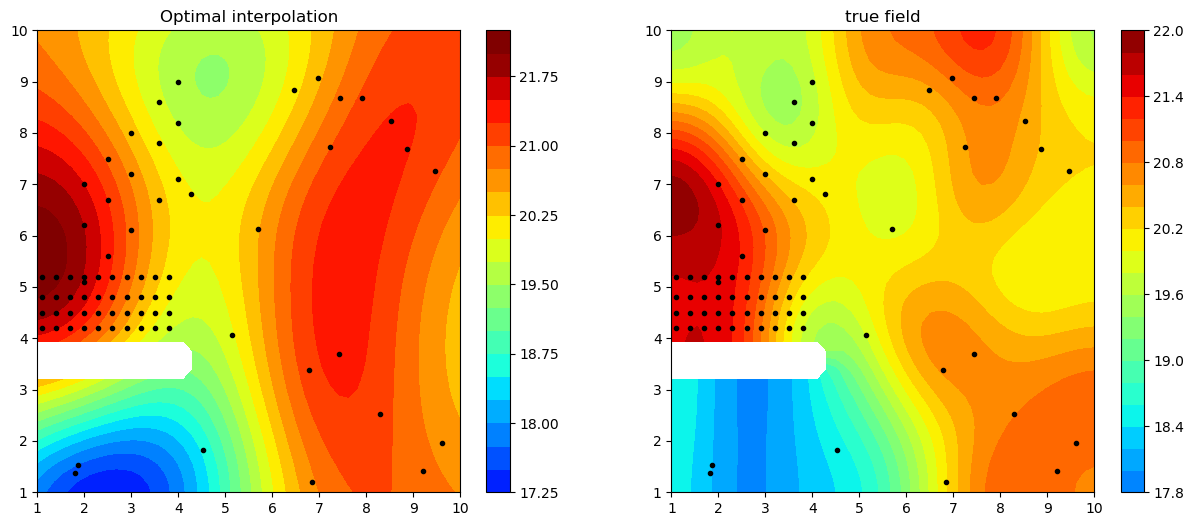

In [18]:
plotfieldcmp(fi); title("Optimal interpolation");

Relative error variance of the gridded field by optimal interpolation

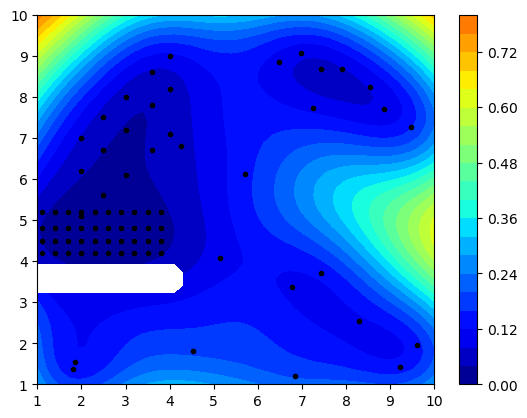

In [19]:
plotfield(vari); clim(0,1)

## Variational Inverse Method and DIVA/DIVAnd

The variational inverse method (VIM) or variational analysis ([Brasseur et al., 1996](https://www.sciencedirect.com/science/article/pii/096706379600012X))
 aims to find a field with the following characteristics:


* __smooth__
* somewhat __close__ to first guess
* __close__ to the observed values

This is achieved by defining a cost function which penalizes a field that doesn't satisfy those requirements.


* ``__close__'' is quantified using the RMS error
* ``__smooth__'' is quantified by averaging the  square of the first and second derivatives of the field (for a slowly varying field those derivatives are small).
* those different requirements are weighted to define what is more important, a smooth field or a field close to observations.


### Equivalence between OI and variational analysis


* The variational inverse method is identical to the optimal interpolation analysis if the weights are defined as the inverse of the covariance matrix used in optimal interpolation analysis.
* This allows to compute the weights based on the error covariances
* Error covariance can be obtained by the statistical behaviour of the field

### Error fields by analogy with optimal interpolation

Error fields can be derived since:


* The optimal interpolation analysis is equivalent to VIM if the weights used by VIM are the inverse of the error covariances used by optimal interpolation.
* In the context of optimal interpolation, it can be shown that the error field equals the analysis of the covariance fields
* $\Rightarrow$ error field of VIM equals analysis (by VIM) of covariance fields (the input of the analysis tool is a vector containing the covariance of data points with the point in which the error estimate is to be calculated)


The tools DIVA and DIVAnd implement the variational inverse method.


### Example

Field reconstructed using DIVA implementing the  variational inverse method. Right panel shows true field.


* The results are similar to the field obtained by optimal interpolation. 
* But now, the land-sea boundary is taken into account.





In [20]:
using DIVAnd

In [21]:
# type ?DIVAnd for the documentation of DIVAndrun
len = 2.
epsilon2 = 1/30;
fi,s  = DIVAndrun(mask,(pm,pn),(x,y),(X,Y),Fa,(len,len),epsilon2);

fi = fi .+ meanF;

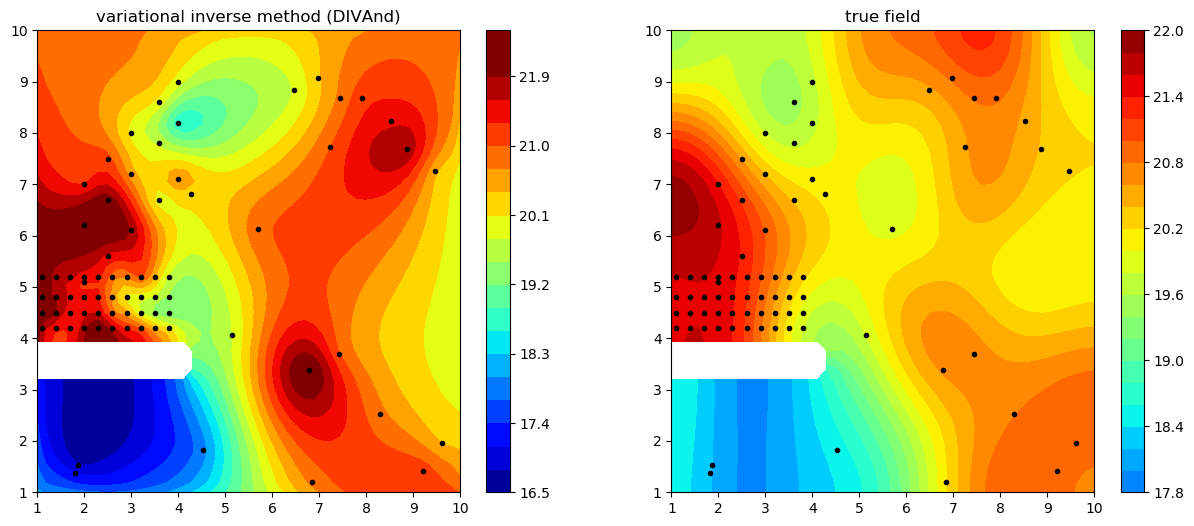

In [22]:
plotfieldcmp(fi); title("variational inverse method (DIVAnd)");

Relative error of the field reconstructed using DIVA


* The error is lowest near the observations and tends to 1 far away from them. 
* The presence of the barrier also impacts the estimation of error variance.
* The error estimate should be interpreted cautiously since we supposed that the used error covariances are correct.


In [23]:
err  = DIVAnd_cpme(mask,(pm,pn),(x,y),(X,Y),Fa,(len,len),epsilon2);

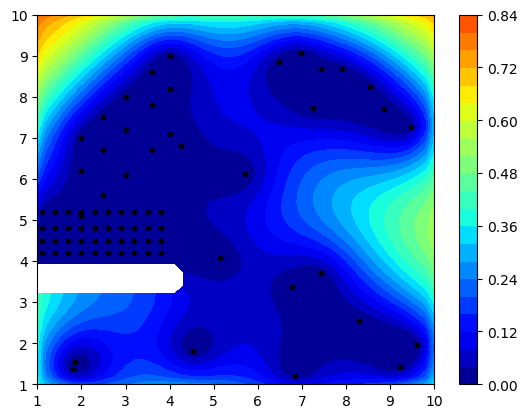

In [24]:
plotfield(err; ca = [0,1]);